<a href="https://colab.research.google.com/github/201ssc/python_test1/blob/main/7_5_%EB%94%94%EC%97%90%ED%84%B0_%EC%8A%A4%EC%BC%80%EC%9D%BC_%EB%B3%80%EA%B2%BD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
#if 'google.colab' in sys.modules and not os.path.isdir('mglearn'):
    # 사이킷런 최신 버전을 설치합니다.
!pip install -q --upgrade scikit-learn
# mglearn을 다운받고 압축을 풉니다.
!wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
!tar -xzf mglearn.tar.gz
# 나눔 폰트를 설치합니다.
!sudo apt-get -qq -y install fonts-nanum
import matplotlib.font_manager as fm
fm._rebuild()

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155676 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [2]:
import sklearn
from preamble import *
import matplotlib

# 나눔 폰트를 사용합니다.
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import matplotlib

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import QuantileTransformer, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=3)
sns.set(rc = {'figure.figsize':(10,6)})

from pandas.core.common import random_state

In [4]:
import os.path

if not os.path.isfile('data/aclImdb_v1.tar.gz'):
  !wget -q http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data
  !tar -xzf data/aclImdb_v1.tar.gz -C data
    

In [5]:
!find ./data -type d
!rm -r data/aclImdb/train/unsup  ## 긍정 부정 레이블이 없는 데이터 삭제

./data
./data/aclImdb
./data/aclImdb/test
./data/aclImdb/test/neg
./data/aclImdb/test/pos
./data/aclImdb/train
./data/aclImdb/train/neg
./data/aclImdb/train/pos
./data/aclImdb/train/unsup


In [6]:
from sklearn.datasets import load_files

reviews_train = load_files("data/aclImdb/train/")
# 텍스트와 레이블을 포함하고 있는 Bunch 오브젝트를 반환합니다.
text_train, y_train = reviews_train.data, reviews_train.target
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

reviews_test = load_files("data/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer() 

In [7]:
vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

## 7.5 tf-idf로 데이터 스케일 변경하기

중요하지 않아 보이는 특성을 제회하는 대신, 얼마나 의미 있는 특성인지를 계산해서 스케일을 조정하는 방식이 있다. tf-idf이다. tf-idf는 말뭉치의 다른 문서보다 특정 문서에 자주 나타나는 단어에 높은 가중치를 주는 방법이다. 한 단어가 특정 문서에 자주 나타나고 다른 여러 문서에서는 그렇지 않다면 그 문서의 내용을 아주 잘 설명하는 단어라고 볼 수 있다. sklearn 은 두개의 파이썬 클래스에 tf-idf를 구현했다. 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
param_grid = {'logisticregression__C': [-.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_train, y_train)
print('최상의 교차 검증 점수: {:.2f}'.format(grid.best_score_))

# tf_idf가 큰 영향을 주지 못했다.
# 비지도 학습이라서 데이터를 보면 예상한 분류와 다른 모습을 띌 수 있다.

최상의 교차 검증 점수: 0.89


In [11]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 훈련 데이터셋을 변환한다.
X_train = vectorizer.transform(text_train)
# 특성별로 가장 큰 값을 찾는다.
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()
# 특성이름을 구한다.
feature_names = np.array(vectorizer.get_feature_names_out())
print("가장 낮은 tfidf를 가진 특성 :\n", feature_names[sorted_by_tfidf[:20]])
print("가장 높은 tfidf를 가진 특성 :\n", feature_names[sorted_by_tfidf[-20:]])

가장 낮은 tfidf를 가진 특성 :
 ['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
가장 높은 tfidf를 가진 특성 :
 ['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


In [13]:
sort_by_idf = np.argsort(vectorizer.idf_)
print('가장 낮은 idf를 가진 특성 : \n', feature_names[sort_by_idf[:100]])

가장 낮은 idf를 가진 특성 : 
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


## 7.6 모델 계수 조사
무엇을 학습 했는지 시각화. 자주 나타나지 않는 단어를 제외해도 특성이 27,271 개나 되기 때문에 모든 계수를 한눈에 볼 수 없다. 따라서 큰 겂의 계수와 해당 단어를 확인해 보자. tf_idf 특성으로 훈련시킨 마지막 모델을 사용한다.
가장큰 계수 40개, 가장 작은 계수 40개

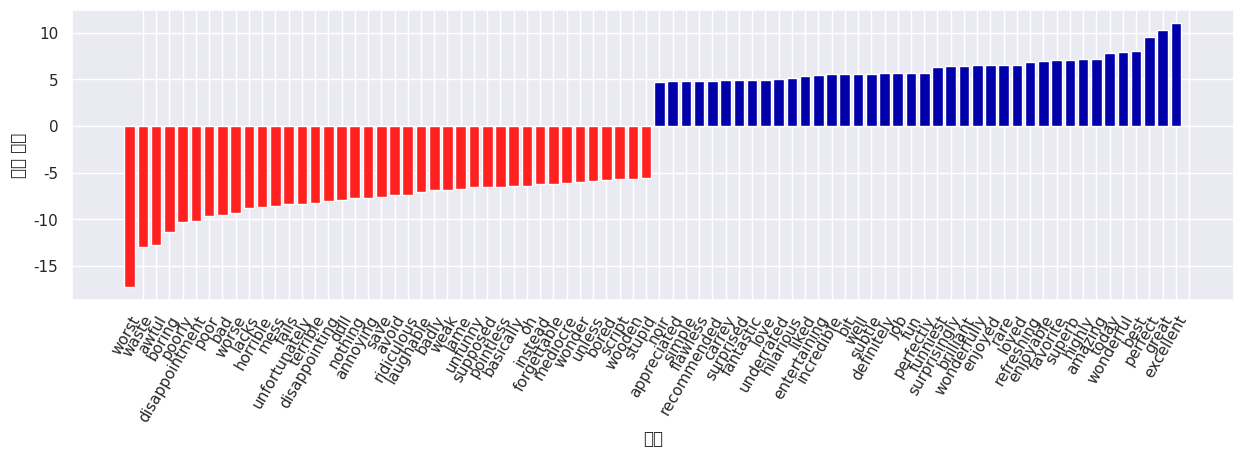

In [14]:
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps['logisticregression'].coef_[0],
    feature_names, n_top_features=40)

## 7.7 여러 단어로 만든 BOW(n-그램)

BOW 표현 방식은 단어의 순서가 완전히 무시된다는 큰 단점이 있다
그래서 극단적인 경우 의미가 반대이지만 동일하게 변환되기도한다.
"it's bad, not good at all", "it's good, not bad at all"

다행이도 BOW 표현 방식을 사용할때 문맥을 고려하는 방법이 있다. 토큰 하나만 고려하지 않고 옆에 있는 두세 개의 토큰을 함께 고려하는 것이다. 토큰 두개를 바이그램, 세개를 트라이그램이라고 하며 일반적으로 연속된 토큰을 n-gram이라고 한다.

In [19]:
bards_words =["The fool doth think he is wise,",
              "but the wise man knows himself to be a fool"]

print("bards_words:\n", bards_words)

bards_words:
 ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


In [20]:
cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print("어휘 사전 크기:", len(cv.vocabulary_))
# get_feature_names() 메서드가 1.0에서 deprecated 되었고 1.2 버전에서 삭제될 예정입니다.
# 대신 get_feature_names_out()을 사용합니다.
print("어휘 사전:\n", cv.get_feature_names_out())

어휘 사전 크기: 13
어휘 사전:
 ['be' 'but' 'doth' 'fool' 'he' 'himself' 'is' 'knows' 'man' 'the' 'think'
 'to' 'wise']


In [21]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print("어휘 사전 크기:", len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names_out())

어휘 사전 크기: 14
어휘 사전:
 ['be fool' 'but the' 'doth think' 'fool doth' 'he is' 'himself to'
 'is wise' 'knows himself' 'man knows' 'the fool' 'the wise' 'think he'
 'to be' 'wise man']


In [22]:
print('변환된 데이터 (밀집 배열):\n', cv.transform(bards_words).toarray())

변환된 데이터 (밀집 배열):
 [[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


단어 하나가 큰 의미를 가진 경우가 많으므로 대부분의 애플리케이션에서 토큰의 최소 길이는 1이다. 많은 경우에 바이그램을 추가하면 도움이 된다. 그러나 많아질수록 구체적인 특성이 많아지기 때문에 과대적합될 가능성이 있다.

In [23]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print("어휘 사전 크기:", len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names_out())

어휘 사전 크기: 39
어휘 사전:
 ['be' 'be fool' 'but' 'but the' 'but the wise' 'doth' 'doth think'
 'doth think he' 'fool' 'fool doth' 'fool doth think' 'he' 'he is'
 'he is wise' 'himself' 'himself to' 'himself to be' 'is' 'is wise'
 'knows' 'knows himself' 'knows himself to' 'man' 'man knows'
 'man knows himself' 'the' 'the fool' 'the fool doth' 'the wise'
 'the wise man' 'think' 'think he' 'think he is' 'to' 'to be' 'to be fool'
 'wise' 'wise man' 'wise man knows']


In [24]:
pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
# 매개변수 조합이 많고 트라이그램이 포함되어 있기 때문에
# 그리드 서치 실행에 시간이 오래 걸립니다
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]} # 추가

grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_train, y_train)
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("최적의 매개변수:\n", grid.best_params_)

최상의 교차 검증 점수: 0.91
최적의 매개변수:
 {'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


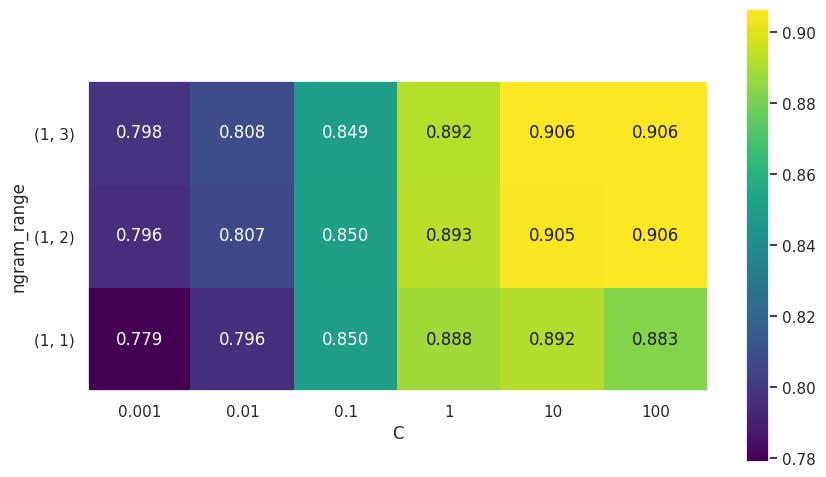

In [25]:
# 그리드 서치에서 테스트 점수를 추출합니다
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# 히트맵을 그립니다
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)
plt.show() # 책에는 없음

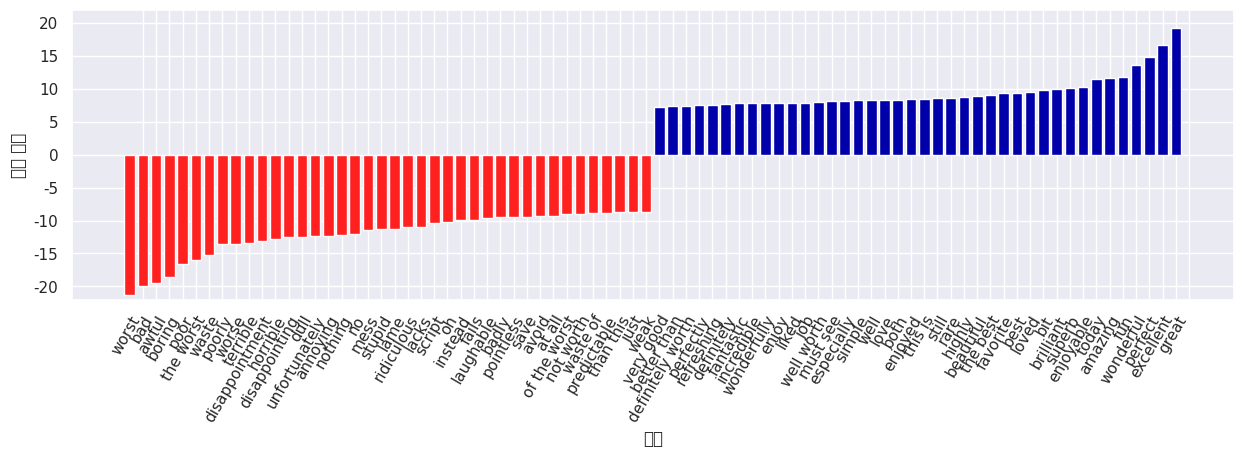

In [26]:
# 특성 이름과 계수를 추출합니다
vect = grid.best_estimator_.named_steps['tfidfvectorizer']
# get_feature_names() 메서드가 1.0에서 deprecated 되었고 1.2 버전에서 삭제될 예정입니다.
# 대신 get_feature_names_out()을 사용합니다.
feature_names = np.array(vect.get_feature_names_out())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)
plt.ylim(-22, 22)
plt.show()

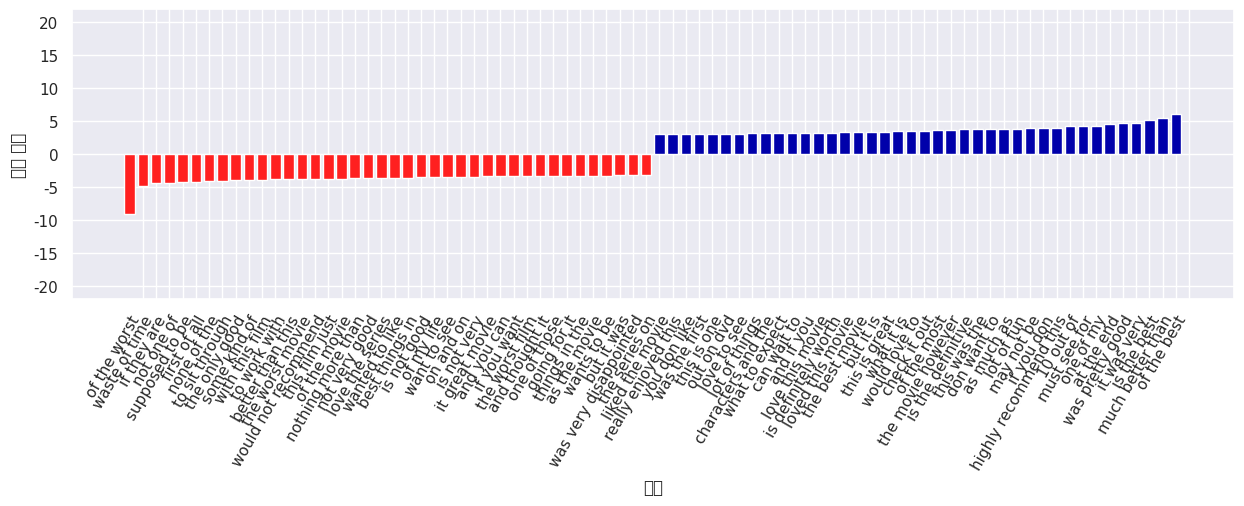

In [27]:
# 트라이그램 특성을 찾습니다
mask = np.array([len(feature.split(" ")) for feature in feature_names]) == 3
# 트라이그램 특성만 그래프로 나타냅니다
mglearn.tools.visualize_coefficients(coef.ravel()[mask],
                                     feature_names[mask], n_top_features=40)
plt.ylim(-22, 22)
plt.show()

## 7.8 고급 토큰화, 어간 추출, 표제어 추출